<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/Q_learning_SARSA_NN_PyTorch_FrozenLaken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning and SARSA with neural network for Frozen Lake (PyTorch)

In this notebook, we will use Q-learning and SARSA with neural network to solve Frozen Lake.


Environment: (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

##Setup

In [ ]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

## Setup a Virtual Display
To generate a replay video of agent and environment.

In [ ]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Let's start by creating the Frozen Lake environment.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=True, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': True, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFF', 'FFFFFFFF', 'FFFFFFFH', 'HFFFFFFF', 'FFFFFFFF', 'FHFFFFFF', 'FHFFFHFF', 'FFFHHFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

##Observing the environment

In [ ]:
# actions: move left=0, move down = 1, move right = 2, move up = 3
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


In [ ]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

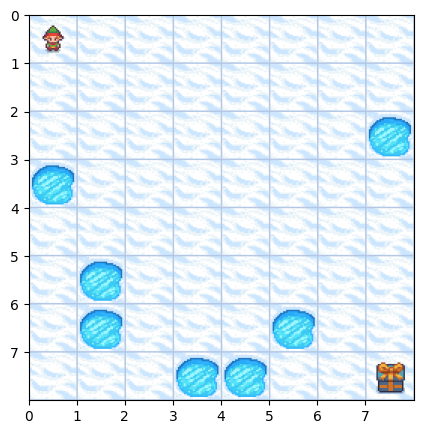

In [ ]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

##Executing random actions

In [ ]:
# Taking a step by selecting a random action[move left=0, move down = 1, move right = 2, move up = 3] from current state
# next_observation: position on the grid
# reward: What rewards did I receive?
# is_terminal: did I end up in the goal state?

print("step number : action, position, reward, terminated, truncated, {info}")

for i in range(20):
    # sample a random action from all valid actions
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("step", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

step number : action, position, reward, terminated, truncated, {info}
step 1 : 0 , move left , 8 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 2 : 1 , move down , 16 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 3 : 3 , move up , 16 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 4 : 1 , move down , 17 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 5 : 0 , move left , 25 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 6 : 3 , move up , 17 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 7 : 3 , move up , 9 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 8 : 3 , move up , 10 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 9 : 0 , move left , 2 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 10 : 0 , move left , 2 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 11 : 3 , move up , 3 , 0.0 , False , False , {'prob': 0.3333333333333333}
step 12 : 3 , move up , 2 , 0.0 , False , False , {'

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

# returns an initial observation
state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 50 : move right , 24 , 0.0 , True , False , {'prob': 0.3333333333333333}


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

##Building an Q-learning agent (off-policy) or a SARSA agent (on-policy)

![QL](https://i.stack.imgur.com/nQotE.png)

## Linear Neural Network

A linear neural network to be used with Q-learning and SARSA algorithms. It is useful for environments where we are not receiving an image as observation.

The input size of the network receives an input of the available environment states.

The output of the network is the Q-value for each available action. So the output size is the shape of the actions state.

The size of the hidden layers is arbitrary. So, it can be varied from one application to another and it is one of the parameters that are worth modifying to ensure greater efficiency in the network.

In [ ]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.sigmoid(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

Q-learning and SARSA Agent

In [ ]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## Hyperparameters

In [ ]:
# hyperparameters
alpha_learning_rate = 0.0001 # @param {type:"number"}
nb_max_episodes = 3000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.n, hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 64 , Hidden = 64 , output = 4
Q-learning agent started


### Test accurracy

In [ ]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [ ]:
def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

## Playing and Training

In [ ]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  3%|▎         | 99/3000 [00:06<03:28, 13.94it/s]

step: 3695, episode: 100, accuracy training: 0.01, accuracy test: 0.1, random move probability: 0.48666666666666814


  7%|▋         | 200/3000 [00:17<09:29,  4.91it/s]

step: 8342, episode: 200, accuracy training: 0.01, accuracy test: 0.22, random move probability: 0.47333333333333627


 10%|█         | 301/3000 [00:27<07:58,  5.64it/s]

step: 12512, episode: 300, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.4600000000000044


 13%|█▎        | 401/3000 [00:34<08:40,  4.99it/s]

step: 16210, episode: 400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 502/3000 [00:45<04:19,  9.62it/s]

step: 21258, episode: 500, accuracy training: 0.05, accuracy test: 0.12, random move probability: 0.4333333333333407


 20%|██        | 601/3000 [00:56<06:28,  6.17it/s]

step: 26024, episode: 600, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4200000000000088


 23%|██▎       | 702/3000 [01:07<09:24,  4.07it/s]

step: 30641, episode: 700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.40666666666667695


 27%|██▋       | 801/3000 [01:16<05:34,  6.57it/s]

step: 35148, episode: 800, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.3933333333333451


 30%|███       | 901/3000 [01:27<09:38,  3.63it/s]

step: 39789, episode: 900, accuracy training: 0.07, accuracy test: 0.06, random move probability: 0.3800000000000132


 33%|███▎      | 1002/3000 [01:37<03:30,  9.51it/s]

step: 44192, episode: 1000, accuracy training: 0.1, accuracy test: 0.44, random move probability: 0.36666666666668135


 37%|███▋      | 1101/3000 [01:46<05:15,  6.02it/s]

step: 48023, episode: 1100, accuracy training: 0.1, accuracy test: 0.14, random move probability: 0.3533333333333495


 40%|████      | 1200/3000 [01:55<05:23,  5.56it/s]

step: 52622, episode: 1200, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.3400000000000176


 43%|████▎     | 1301/3000 [02:04<05:35,  5.06it/s]

step: 56882, episode: 1300, accuracy training: 0.16, accuracy test: 0.42, random move probability: 0.32666666666668576


 47%|████▋     | 1400/3000 [02:16<09:45,  2.73it/s]

step: 62012, episode: 1400, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.3133333333333539


 50%|█████     | 1501/3000 [02:26<06:59,  3.58it/s]

step: 66874, episode: 1500, accuracy training: 0.17, accuracy test: 0.7, random move probability: 0.300000000000022


 53%|█████▎    | 1600/3000 [02:36<04:34,  5.10it/s]

step: 71680, episode: 1600, accuracy training: 0.18, accuracy test: 0.36, random move probability: 0.28666666666669016


 57%|█████▋    | 1700/3000 [02:47<03:16,  6.62it/s]

step: 76759, episode: 1700, accuracy training: 0.15, accuracy test: 0.1, random move probability: 0.2733333333333583


 60%|██████    | 1801/3000 [02:59<03:07,  6.41it/s]

step: 82298, episode: 1800, accuracy training: 0.22, accuracy test: 0.56, random move probability: 0.26000000000002643


 63%|██████▎   | 1901/3000 [03:09<03:32,  5.17it/s]

step: 87094, episode: 1900, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2003/3000 [03:21<02:58,  5.60it/s]

step: 92441, episode: 2000, accuracy training: 0.31, accuracy test: 0.42, random move probability: 0.23333333333335923


 70%|███████   | 2101/3000 [03:32<04:46,  3.14it/s]

step: 97416, episode: 2100, accuracy training: 0.33, accuracy test: 0.74, random move probability: 0.2200000000000246


 73%|███████▎  | 2202/3000 [03:43<02:14,  5.92it/s]

step: 102652, episode: 2200, accuracy training: 0.33, accuracy test: 0.86, random move probability: 0.20666666666668995


 77%|███████▋  | 2302/3000 [03:54<02:26,  4.76it/s]

step: 108209, episode: 2300, accuracy training: 0.31, accuracy test: 0.8, random move probability: 0.1933333333333553


 80%|████████  | 2401/3000 [04:06<01:42,  5.86it/s]

step: 113374, episode: 2400, accuracy training: 0.42, accuracy test: 0.7, random move probability: 0.18000000000002067


 83%|████████▎ | 2500/3000 [04:15<01:03,  7.89it/s]

step: 118031, episode: 2500, accuracy training: 0.41, accuracy test: 0.38, random move probability: 0.16666666666668603


 87%|████████▋ | 2603/3000 [04:28<01:23,  4.76it/s]

step: 123565, episode: 2600, accuracy training: 0.37, accuracy test: 0.46, random move probability: 0.1533333333333514


 90%|█████████ | 2701/3000 [04:38<01:26,  3.47it/s]

step: 128730, episode: 2700, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.14000000000001675


 93%|█████████▎| 2801/3000 [04:48<00:25,  7.93it/s]

step: 133806, episode: 2800, accuracy training: 0.42, accuracy test: 0.34, random move probability: 0.1266666666666821


 97%|█████████▋| 2901/3000 [05:00<00:18,  5.30it/s]

step: 139213, episode: 2900, accuracy training: 0.48, accuracy test: 0.98, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [05:11<00:00,  9.62it/s]

step: 144617, episode: 3000, accuracy training: 0.45, accuracy test: 0.9, random move probability: 0.10000000000001544



/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 64 : move down , 63 , 1.0 , True , False , {'prob': 0.3333333333333333}


In [ ]:
# You should get a video similar to the one below.
html = render_mp4(after_training)
HTML(html)

### Metrics

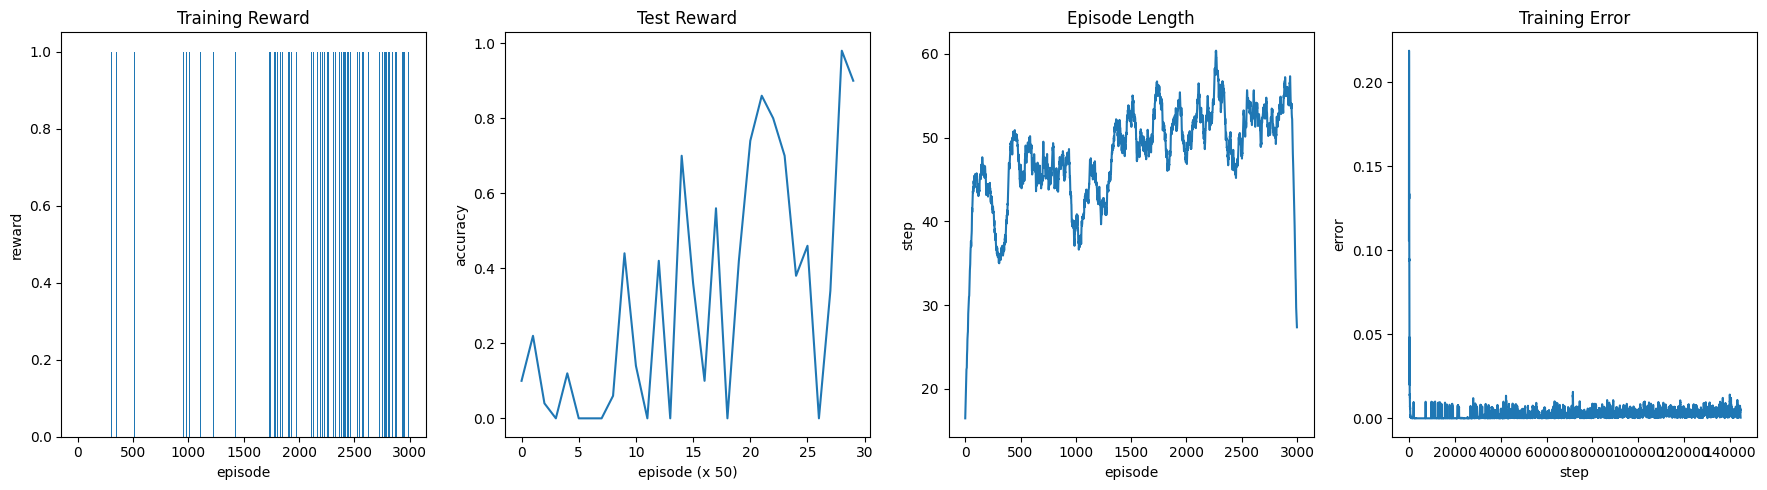

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
def qtable_directions_map(qtable_val_max, qtable_best_action, map_size):
    """Get the best learned action & map it to arrows."""
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [ ]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

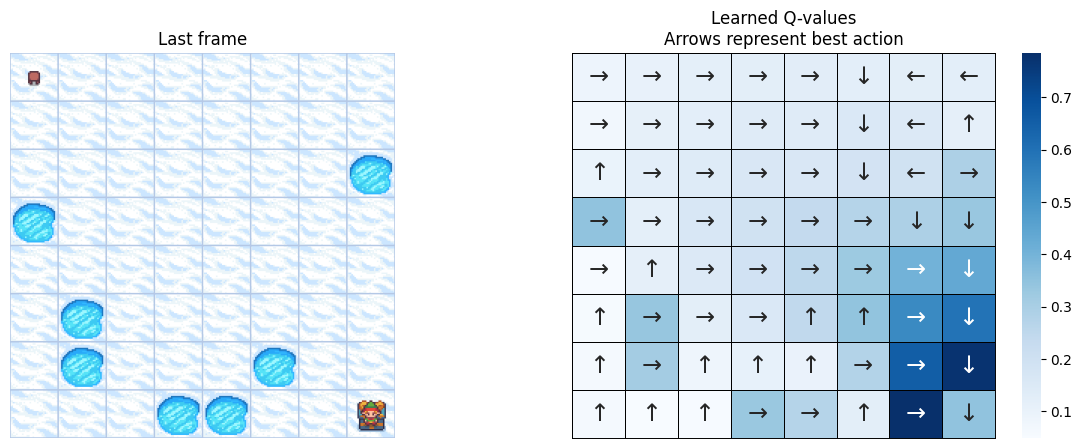

In [ ]:
qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)